In [42]:
%pip install emoji

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import re
import time
import emoji
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tqdm.auto import tqdm
import tensorflow as tf
#%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [45]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [46]:
TRAIN_DATA_PATH = '/content/train.csv'
TEST_DATA_PATH = '/content/test.csv'
SAVED_MODEL_PATH = '/content/model.keras'
VOCAB_SIZE = 10000  # Vocabulary size for tokenizer
EMBEDDING_DIM = 100  # Embedding dimension for LSTM
MAX_LEN = 128  # Maximum sequence length
BATCH_SIZE = 32
NUM_CLASSES = 2
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5

print("Configuration Loaded Successfully!")

Configuration Loaded Successfully!


In [47]:
def clean_text(text):
    """Cleans text by removing emojis, special characters, lowercasing, stemming, and lemmatizing."""
    text = emoji.replace_emoji(text, replace="")
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = " ".join(text.split())
    words = text.split()
    words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words if word.lower() not in stop_words]
    return " ".join(words)

In [48]:
def preprocess_texts(texts, tokenizer=None, fit_tokenizer=False,
                     num_words=10000, maxlen=100, oov_token='<OOV>'):
    # Clean
    cleaned = [clean_text(t) for t in texts]

    # Tokenizer
    if tokenizer is None and fit_tokenizer:
        tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
        tokenizer.fit_on_texts(cleaned)
    elif tokenizer is None:
        raise ValueError("Tokenizer must be provided if not fitting a new one.")

    # Text to sequences
    seqs = tokenizer.texts_to_sequences(cleaned)
    # Pad
    padded = pad_sequences(seqs, maxlen=maxlen, padding='post', truncating='post')

    return padded, tokenizer

In [49]:
data = pd.read_csv(TRAIN_DATA_PATH).drop_duplicates()
data = data.dropna(subset=['text'])
data = data[data['style'] != 'formality']  # Drop rows where style is 'formality'
data = data[data['label_text'] != 'neutral']
print(f'Number of samples after dropping NaN and "formality" style: {len(data)}')
data.head()
print(data['label_text'].value_counts())

Number of samples after dropping NaN and "formality" style: 77616
label_text
positive         33361
negative         27711
very positive     9311
very negative     7233
Name: count, dtype: int64


In [50]:
data2 = pd.read_csv(TEST_DATA_PATH).drop_duplicates()
data2 = data2.dropna(subset=['text'])
data2 = data2[data2['style'] != 'formality']  # Drop rows where style is 'formality'
data2 = data2[data2['label_text'] != 'neutral']
print(f'Number of samples after dropping NaN and "formality" style: {len(data2)}')
data2.head()
print(data2['label_text'].value_counts())

Number of samples after dropping NaN and "formality" style: 1821
label_text
negative         633
positive         510
very positive    399
very negative    279
Name: count, dtype: int64


In [51]:
data['label_text'] = data['label_text'].apply(
    lambda x: 0 if x in ['very negative', 'negative'] else 1
)
data.head()

data2['label_text'] = data2['label_text'].apply(
    lambda x: 0 if x in ['very negative', 'negative'] else 1
)


In [52]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(data))
list_tokenized_train = tokenizer.texts_to_sequences(data)
list_tokenized_test = tokenizer.texts_to_sequences(data)

In [53]:
num_words = 10000
maxlen = 100

# Preprocess training data and fit tokenizer
X_all, tokenizer = preprocess_texts(
    data['text'],
    tokenizer=None,
    fit_tokenizer=True,
    num_words=num_words,
    maxlen=maxlen
)

y_all = data['label_text'].values

# Preprocess test data using the same tokenizer
X_test, _ = preprocess_texts(
    data2['text'],
    tokenizer=tokenizer,
    fit_tokenizer=False,
    maxlen=maxlen
)

y_test = data2['label_text'].values

# Split a validation set from training
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)


In [54]:
# Parameters
max_features = 10000  # Top 10,000 words
maxlen = 100  # Maximum length of reviews (in terms of words)
embed_size = 128

In [55]:
from tensorflow.keras.layers import Input, Embedding, GRU, GlobalMaxPool1D, Dropout, Dense
from tensorflow.keras.models import Model

# Input and Embedding
inp = Input(shape=(maxlen,))
x = Embedding(input_dim=max_features, output_dim=embed_size)(inp)

# GRU Layer
output_dimension = 60
x = GRU(output_dimension, return_sequences=True, name='gru_layer')(x)

# Reduce dimensionality
x = GlobalMaxPool1D()(x)

# Dropout and Dense layers
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)

# Output layer for binary classification
x = Dense(1, activation="sigmoid")(x)


In [56]:
# Compile model
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_layer (GRU)                 │ (None, 100, 60)        │        34,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 60)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,301 (5.03 MB)

 Trainable params: 1,317,301 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
print('Training Model...')
start_fitting = time.time()
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(X_val, y_val)
)
fitting_model_time = time.time()
print(f'Training Model took: {fitting_model_time - start_fitting:.2f} seconds')

Training Model...
Epoch 1/5
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7590 - loss: 0.4892 - val_accuracy: 0.8866 - val_loss: 0.2866
Epoch 2/5
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9148 - loss: 0.2281 - val_accuracy: 0.8973 - val_loss: 0.2651
Epoch 3/5
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9369 - loss: 0.1636 - val_accuracy: 0.8993 - val_loss: 0.2639
Epoch 4/5
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9475 - loss: 0.1295 - val_accuracy: 0.9038 - val_loss: 0.2843
Epoch 5/5
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9553 - loss: 0.1086 - val_accuracy: 0.9031 - val_loss: 0.3282
Training Model took: 98.11 seconds


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix:
[[644 268]
 [143 766]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.82      0.71      0.76       912
     Class 1       0.74      0.84      0.79       909

    accuracy                           0.77      1821
   macro avg       0.78      0.77      0.77      1821
weighted avg       0.78      0.77      0.77      1821



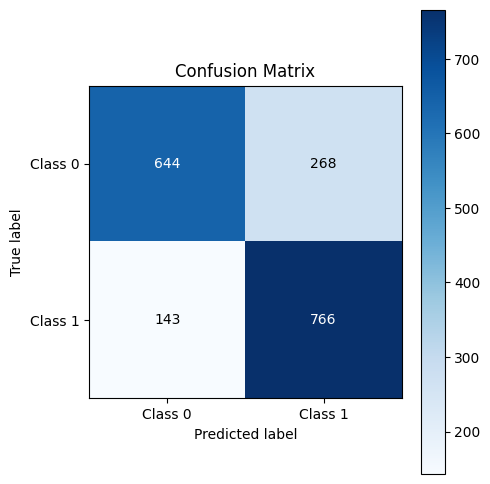

In [58]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

probs = model.predict(X_test)

if probs.ndim == 2 and probs.shape[1] > 1:
    y_pred = np.argmax(probs, axis=1)
else:
    y_pred = (probs.reshape(-1) > 0.5).astype(int)

y_true = y_test

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0','Class 1'])
plt.yticks(tick_marks, ['Class 0','Class 1'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [59]:
# Save the model to a file
model.save("GRU.keras")